# ASSIGNMENT 4


## Part 1

Nonparametric estimation is a statistical method that allows the functional form of a fit to data to be obtained in the absence of any guidance or constraints from theory [1]. There are two kinds of nonparametric estimation techniques available:one is called **Kernel Density Estimation (KDE) or Parzen Windows** and the other is **the k-nearest neighbor-density estimate**. They are fundamentally very similar, but exhibit some different statistical properties [2].

In Part 1 you will make density estimation by using Kernel Density Estimation (Parzen) and kNN from non-parametric density estimation methods and, make classification via Bayesian aproach. In this context, you are given the train and test datasets generated from bimodal 2D Gaussian distributions for two-classes. You are expected to:

1- For each sample *x* at the test set, compute the density estimation (i.e. estimated probabilities of samples using KDE and kNN) to obtain a likelihood P(x | C), for each class C.

2- From the number of examples of each class in the training set, compute the class prior, P(C).

3- For each test point x, get an estimate for the posterior probability for each class is P(C|x)∝P(x|C)P(C). The class which maximizes this posterior is the label assigned to the point.

4-Finally, save your result for each sample with the classification labels in a csv file. 

You are expected to find the Kernel Density estimation using Gaussian Kernels (check the lecture notes for the details) with your own implementations. Make some experiments to determine the best bandwidth for your kernels. You may check your estimations using the Scikitlearn libraries; this tutorial could be helpful as a starter [3].






[1]: https://mathworld.wolfram.com/NonparametricEstimation.html#:~:text=Nonparametric%20estimation%20is%20a%20statistical,have%20no%20meaningful%20associated%20parameters.

[2]:https://www.cs.cmu.edu/~epxing/Class/10701-08s/reading/R1-b.pdf

[3]:https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html 


In [1]:
import numpy as np
import pandas as pd


def read_dataset(filename):
    df = pd.read_csv(filename, index_col=0)
    arr = np.array(df)
    return arr

def gaussian_kernel(x, h):
    return np.exp(-(x ** 2) / (2 * h ** 2)) / (2 * np.pi * h ** 2)

def kernel_density_estimation(dataset, h):
    n = len(dataset[0])
    x0_range = np.linspace(np.min(dataset[0]), np.max(dataset[0]), n)
    x1_range = np.linspace(np.min(dataset[1]), np.max(dataset[1]), n)
    density = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            x0 = x0_range[i]
            x1 = x1_range[j]
            kernel_sum = .0
            for k in range(n):
                kernel_sum += gaussian_kernel(x0 - dataset[0, k], h) * gaussian_kernel(x1 - dataset[1, k], h)
            density[i, j] = kernel_sum / (n * h ** 2)
    
    return density

def k_nearest_neighbor_density(train_dataset, test_dataset, k, divider):
    n = len(test_dataset[0])
    predictions = []

    for i in range(n):
        distances = np.linalg.norm(
            train_dataset - test_dataset[:, i, np.newaxis], axis=0)
        k_nearest_indices = np.argsort(distances)[:k] # Sort and get indices of k nearest
        prediction = 1 if np.average(
            np.where(k_nearest_indices < divider, 1, 0)) > 0.5 else 2 # Majority voting for binary case
        predictions.append(prediction)

    return np.array(predictions)


class1_dataset = read_dataset("Datasets/Part1/Class1.csv")
class2_dataset = read_dataset("Datasets/Part1/Class2.csv")
test_dataset = read_dataset("Datasets/Part1/Test.csv")

# Kernel Density Estimations Tests
bandwiths = [0.25, 0.5, 1]
for bandwith in bandwiths:
    class1_density = kernel_density_estimation(class1_dataset, bandwith)
    class2_density = kernel_density_estimation(class2_dataset, bandwith)
    
    pred = []
    for pt in class1_dataset.T:
        pt = np.repeat(pt[..., None], len(class1_dataset[0]), axis=1)
        class1_density = np.mean(gaussian_kernel(pt - class1_dataset, bandwith))
        class2_density = np.mean(gaussian_kernel(pt - class2_dataset, bandwith))
        if class1_density >= class2_density:
            pred.append(1)
        else:
            pred.append(0)
            
    for pt in class2_dataset.T:
        pt = np.repeat(pt[..., None], len(class2_dataset[0]), axis=1)
        class1_density = np.mean(gaussian_kernel(pt - class1_dataset, bandwith))
        class2_density = np.mean(gaussian_kernel(pt - class2_dataset, bandwith))
        if class2_density > class1_density:
            pred.append(1)
        else:
            pred.append(0)
    
    print(f"Bandwith:\t{bandwith}\tPrecision:\t{np.mean(pred)}")

# k-Nearest Neighbor Tests
ks = [3, 5, 7]
for k in ks:
    train_data = np.concatenate([class1_dataset, class2_dataset], axis=1)
    pred1 = k_nearest_neighbor_density(train_data, class1_dataset, k, len(class1_dataset[0]))
    pred2 = k_nearest_neighbor_density(train_data, class2_dataset, k, len(class2_dataset[0]))
    pred = np.concatenate([np.where(pred1 == 1, 1, 0), np.where(pred2 == 2, 1, 0)])
    
    print(f"k:\t{k}\tPrecision:\t{np.mean(pred)}")


Bandwith:	0.25	Precision:	0.994
Bandwith:	0.5	Precision:	0.992
Bandwith:	1	Precision:	0.992
k:	3	Precision:	1.0
k:	5	Precision:	1.0
k:	7	Precision:	1.0


As one can see bandwidth 0.25 has better results, thus should be used. On the other hand, k choices seems to have no effect on results. Thus k = 5 chosen to use for test data.
Below cell is just used for making predictions.

In [2]:
class1_density = kernel_density_estimation(class1_dataset, 0.25)
class2_density = kernel_density_estimation(class2_dataset, 0.25)

pred = []
for pt in test_dataset.T:
    pt = np.repeat(pt[..., None], len(class1_dataset[0]), axis=1)
    class1_density = np.mean(
        gaussian_kernel(pt - class1_dataset, bandwith))
    class2_density = np.mean(
        gaussian_kernel(pt - class2_dataset, bandwith))
    if class1_density >= class2_density:
        pred.append(1)
    else:
        pred.append(2)

results = pd.read_csv("Datasets/Part1/Test.csv",
                      index_col=0).transpose().rename(columns={0: "x1", 1: "x2"})
results["w"] = pred
results.to_csv("kernel_density_est.csv")

train_data = np.concatenate([class1_dataset, class2_dataset], axis=1)
pred = k_nearest_neighbor_density(
    train_data, test_dataset, 5, len(class1_dataset[0]))
results["w"] = pred
results.to_csv("knn_density_est.csv")

## Part 2 

In statistics, maximum likelihood estimation (MLE) is a method of estimating the parameters of an assumed probability distribution, given some observed data [4]. Maximum Likelihood Estimation requires that the data are sampled from a multivariate normal distribution [5]. 

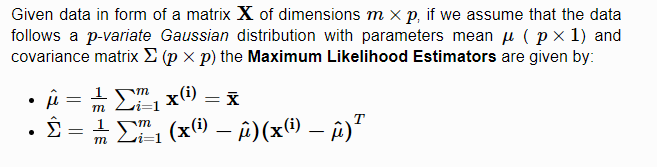

This part consists of 3 steps explained below.

Note: Don't forget to add comments in your codes.

[4]: https://en.wikipedia.org/wiki/Maximum_likelihood_estimation#:~:text=In%20statistics%2C%20maximum%20likelihood%20estimation,observed%20data%20is%20most%20probable.

[5]: https://online.stat.psu.edu/stat505/lesson/12/12.7

**Step 1 :** You are provided two CSV files that contains samples derived from two bivariate Gaussian distributions separately; Class1.csv corresponds to $w_{1}$ class distribution, Class2.csv to $w_{2}$.  Estimate the parameters of these distributions using the max-likelihood estimates (given above) on the given data samples for both classes. 

Write your codes in the cells shared below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_dataset(file):
    df = pd.read_csv(file).transpose()
    x0 = df[0].values[1:]
    x1 = df[1].values[1:]
    return x0, x1

def get_maxLikeliHood_estimates(x0, x1):
    mu = np.array([np.mean(x0), np.mean(x1)])
    sigma = np.cov(x0, x1)
    return mu, sigma

def get_range(class1, class2, n):
    min_ = np.min([class1, class2])
    max_ = np.max([class1, class2])
    return np.linspace(min_, max_, n)

def get_w(mu, sigma, grid):
    log = np.log(np.linalg.det(sigma))
    w = np.sum(np.dot(grid - mu, np.linalg.inv(sigma)) * (grid - mu), axis=-1)
    return log - 0.5 * w


class1_x0, class1_x1 = load_dataset('Datasets/Part2/Class1.csv')
class2_x0, class2_x1 = load_dataset('Datasets/Part2/Class2.csv')
n = max(class1_x0.shape[0], class2_x0.shape[0])

# Max Likelihood Estimators

class1_mu, class1_sigma = get_maxLikeliHood_estimates(class1_x0, class1_x1)
class2_mu, class2_sigma = get_maxLikeliHood_estimates(class2_x0, class2_x1)

# Calculate distribution paramters

x0 = get_range(class1_x0, class2_x0, n)
x1 = get_range(class1_x1, class2_x1, n)
X0, X1 = np.meshgrid(x0, x1) # Get mesh
GRID = np.array([X0.flatten(), X1.flatten()]).T # Creating a grid to calculate distributions over it

w1 = get_w(class1_mu, class1_sigma, GRID)
w2 = get_w(class2_mu, class2_sigma, GRID)

**Step 2 :** Write a program to find the decision boundaries between the two distributions for $w_{1}$ and $w_{2}$; and plot them. 

Please explain briefly, why the decision boundary is in the form that you obtained? 

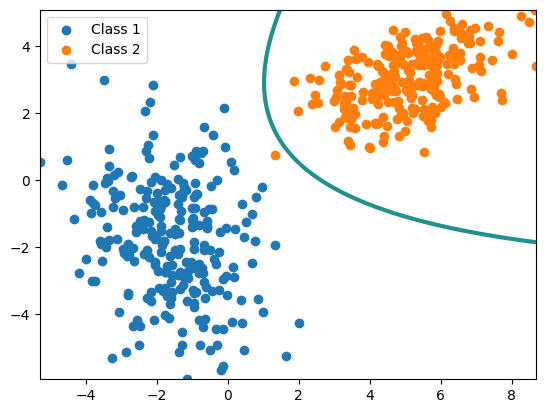

In [23]:
decision_boundary = w1 - w2
decision_boundary = decision_boundary.reshape(X0.shape)

plt.scatter(class1_x0, class1_x1, label='Class 1')
plt.scatter(class2_x0, class2_x1, label='Class 2')
plt.contour(X0, X1, decision_boundary, levels=1, linewidths=3)
plt.legend()
plt.show()

### EXPLANATION
The decision boundary obtained represents the points in the feature space where the probabilities of the two distributions, w1 and w2, are equal (or similar to each other). This means that at the decision boundary, the classifier is uncertain about which class a particular point belongs to.

The decision boundary is influenced by the means of the distributions, which determine the centers of the distributions, and the covariances, which affect the shape and orientation of the distributions.

---

**Step 3 :** You are provided a set of test samples in another CSV file. For each sample in that file, assign the given test samples to the appropriate classes according to the Bayesian Minimum Error-Rate principle. 

Provide the classification results in tabular form; each row contains the data in the form: ($x_{i_1}$, $x_{i_2}$, $w_{i}$), where $x_{i_1}$ and $x_{i_2}$ represents the value of the first and the second features, respectively; $w_{i}$ represents the assigned class index, i.e. 1 or 2. 

Plot your classification result. Make sure that all samples are depicted in one plot embedded on the computed 
densities with a distinguished color.

Use following prior probabilities: 

Case 1: P($w_{1}$) = P($w_{2}$) = 0.5

Case 2: P($w_{1}$) = 0.8, P($w_{2}$) = 0.2

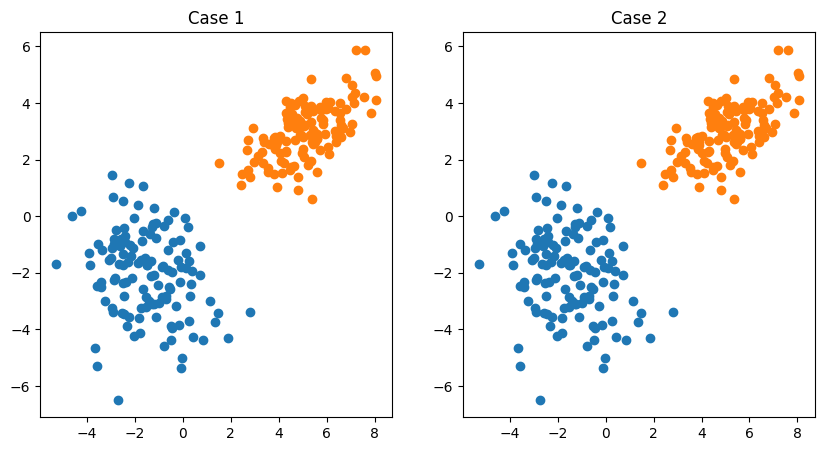

In [32]:
def predict(pt, p):
    w1 = get_w(class1_mu, class1_sigma, pt)
    w2 = get_w(class2_mu, class2_sigma, pt)
    
    if p * w1 > (1 - p) * w2:
        return 1
    return 2

test_x0, test_x1 = load_dataset('Datasets/Part2/test.csv')

# Case 1
pred = []
for pt in zip(test_x0, test_x1):
    pred.append(predict(pt, 0.5))
results = pd.read_csv("Datasets/Part2/test.csv",
                      index_col=0).transpose().rename(columns={0: "x1", 1: "x2"})
results["w"] = pred
results.to_csv("MLE_case1.csv")

# Case 2
pred = []
for pt in zip(test_x0, test_x1):
    pred.append(predict(pt, 0.8))
results = pd.read_csv("Datasets/Part2/test.csv",
                      index_col=0).transpose().rename(columns={0: "x1", 1: "x2"})
results["w"] = pred
results.to_csv("MLE_case2.csv")

def plot_results(file, axis):
    df = pd.read_csv(file)
    
    ones = df[df["w"] == 1]
    x0 = ones["x1"].values[1:]
    x1 = ones["x2"].values[1:]
    
    axis.scatter(x0, x1)
    
    twos = df[df["w"] == 2]
    x0 = twos["x1"].values[1:]
    x1 = twos["x2"].values[1:]
    
    axis.scatter(x0, x1)


figure, axis = plt.subplots(1, 2, figsize=(10, 5))
plot_results("MLE_case1.csv", axis[0])
axis[0].set_title("Case 1")
plot_results("MLE_case2.csv", axis[1])
axis[1].set_title("Case 2")
plt.show()


#### Note1: Don't forget add comments in your codes.
#### Note2: You should implement each part yourself without libraries such as scipy, scikit-learn, statsmodel. You can use functions from libraries like numpy, pandas etc. 